# Location Optimization Analysis for Satisfactory
`Version: 0.4`<br>
`Author: Landon Airey`<br>
`Contributor: Anthor (EDSM/SCIM)`

### The intended use of this tool is to rank positions on the map that minimize total distances to resources needed to meet the input requirements of a factory plan
### The results of the analyis will help inform the player of where to build a factory based on resource logistics
Example workflow:
1. Configure your factory on https://satisfactory-calculator.com/en/planners/production
1. Capture Resource Types and Resource Rates needed
1. Enter **parameters** and Run the python script
1. Review the results (heatmap of the world and best global location) to see if it fits the need of the player


Note **parameters** that the user can modify in the below script:<br>
`findRates`<br>
`findTypes`<br>
`num_foundations_per_step`


## Versions
0.1 First draft of main functions<br>
0.2 Reduced processing time by separating out the 'PreProcess' section<br>
0.3 Fixed incorrect indexing on best_node_ids calculation, cumulative_distance array. Transposed heatmap for proper viewing<br>
0.4 Added Oil Resource Well locations to the csv dataset

In [1]:
#ToDo:
#add Nitrogen Gas resource well locations
#checks for correct input ranges, null lists, etc.
#incorporate z location in distance calculation
#toggle on or off reource nodes that are open/occupied in the world
#report top 10-20 best locations
#add pruning to current_list that removes lower purity nodes if possible
#chance distance calculation to be the lessor of the two: sum of all distances (like it is currently) or sum of connecting a group of nodes, then connecting that group to the grid point via X number of full mk5 belt/mk2 pipes

## Setup

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from PIL import Image
import time

begin_tic = time.time()

In [3]:
#read in csv of world resource nodes into dataframe, change name if needed
df = pd.read_csv('/drive/data/Satisfactory - Nodes.json.csv')

## Input Parameters

In [4]:
#search terms, modify these based on the input resource types and rates required
# Example:
# findRates = [160, 240, 480, 240]
# findTypes = ['copper', 'quartz', 'bauxite', 'coal']
findRates = [138, 69, 118, 197]
findTypes = ['copper', 'iron', 'quartz', 'limestone']

#TODO add check that the rates are within a valid search range, and the types exist/are spelled right

## Grid Search Parameters

In [5]:
#This tool divides the world space into a grid and analyzes each location on the grid for it's proximity to the nearest resource nodes needed
#The user can change the num_foundations_per_step parameter to adjust the grid size/ speed of the analysis 

#these units are in cm
#distance from x_start to x_stop is 797200cm or 7972m or 7.972km or 996.5foundations (each foundation is 8m)
grid_x_start = -340000
grid_y_start = -345000
grid_x_stop = 457200
grid_y_stop = 335000

#setup grid search resolution, set num_foundations_per_step to 50 as a quick first pass. recommended is 10 for a better resolution heatmap
num_foundations_per_step = 20 
foundation_length = 8 #in meters
grid_step = num_foundations_per_step * foundation_length * 100 #convert to cm

#a grid step of 10 foundations will define a grid of ~100x85 points to observe, or ~8500 array entries
print('Number of X Steps: ' + str(round((grid_x_stop-grid_x_start)/grid_step)))
print('Number of Y Steps: ' + str(round((grid_y_stop-grid_y_start)/grid_step)))
total_points = round((grid_x_stop-grid_x_start)/grid_step) * round((grid_y_stop-grid_y_start)/grid_step)
print('Total Map Points to Analyze: ' + str(total_points))

Number of X Steps: 50
Number of Y Steps: 42
Total Map Points to Analyze: 2100


## PreProcess

In [6]:
tic = time.time()

#sort df into list of locations for each resource type

type_locations = [] #list of 'locations' array for each resource type being searched for

for t in range(len(findTypes)): #loop through all types we need to analyze
    locations = np.array([]) #locations will be df idx, xloc, yloc
    count=0
    for n in range(len(df.index)): #loop through all resource nodes
        if df.iloc[n][4] == findTypes[t]: #check if the node matches the type 
            locations = np.append(locations, [n, df.iloc[n][1], df.iloc[n][2]]) #save entry to locations array
            count += 1
    
    locations = locations.reshape(count, 3) #reshape to 2d
    type_locations.append(locations) #add locations array to the list
    
elapsed = time.time() - tic
print('Time Elapsed [s]: '+ str(elapsed))

Time Elapsed [s]: 0.2970001697540283


## Main Loop

In [7]:
tic = time.time()

closest_grid_list = [] #list of closest node indexes to each grid point that satisfies the rate requirements
rate_running_total = 0 #running total of rate from the current collection of nodes relative to any given gride point
cumulative_distance = np.full((round((grid_x_stop-grid_x_start)/grid_step), round((grid_y_stop-grid_y_start)/grid_step)), 0) #2d array of cumulative distances of all listed node locations per grid point, indexed (y,x)

print('Analyzing ' + str(total_points) + ' locations against ' + str(len(findTypes)) + ' different types of resources')
                        
for x in range(round((grid_x_stop-grid_x_start)/grid_step)): #round((grid_x_stop-grid_x_start)/grid_step)
    print(str(x) + '/' + str(round((grid_x_stop-grid_x_start)/grid_step)-1) + ' completed')
    for y in range(round((grid_y_stop-grid_y_start)/grid_step)): #round((grid_y_stop-grid_y_start)/grid_step)
        #inner loop code
        current_distance_total = 0 #reset for each grid point
        
        current_x = grid_x_start + x*num_foundations_per_step*foundation_length*100
        current_y = grid_y_start + y*num_foundations_per_step*foundation_length*100
        #print([current_x, current_y])
        
        
        ###
        ### loop through each resource type 
        ###
        #type_locations = [] #list of 'locations' array for each resource type being searched for for this x,y loop
        type_distances = [] #list of 'distances' array for each resource type being searched for for this x,y loop
        
        for t in range(len(findTypes)):
        
            ###
            ### loop through each matching type node and calculate distance to the current grid point, store in 'distances'
            ###
            
            distances = np.array([]) #distances will be match idx, distance

            for n in range(len(type_locations[t])):
                current_node_loc = np.array([type_locations[t][n][1], type_locations[t][n][2]])
                current_grid_loc = np.array([current_x, current_y])
                current_distance = np.linalg.norm(current_node_loc - current_grid_loc)
                distances = np.append(distances, [type_locations[t][n][0], current_distance])
            
            distances = distances.reshape(len(type_locations[t]), 2) #reshape to 2d
            distances = distances[distances[:, 1].argsort()] #sort by distance
            type_distances.append(distances) #save to list
        
        ###
        ### loop through rates of each resource rate 
        ###
        for r in range(len(findRates)):
            rate_running_total = 0
            current_list = [] #current list of nodes that add up to the desired rate that will get appended to the larger closest_grid_list for each grind point

            ###
            ### loop through 'locations' to find the closest nodes that add up to the desired rate
            ###
            
            for n in range(len(type_distances[r])):
                rate_running_total += df.iloc[int(type_distances[r][n,0])][8]
                current_distance_total += type_distances[r][n,1]
                current_list.append(int(type_distances[r][n,0]))
                if rate_running_total >= findRates[r]:
                    break #if we meet the rate requirement then don't add any more to the current_list

            closest_grid_list.append(current_list)
            
        
        ###
        ### save current list to the larger closest_grid_list for the current grid point
        ###
        cumulative_distance[x,y] = current_distance_total
        
        
    1 #buffer code block to appease the indentation gods
#buffer code block to appease the indentation gods

elapsed = time.time() - tic
print('Time Elapsed [s]: '+ str(elapsed))

Analyzing 2100 locations against 4 different types of resources
0/49 completed
1/49 completed
2/49 completed
3/49 completed
4/49 completed
5/49 completed
6/49 completed
7/49 completed
8/49 completed
9/49 completed
10/49 completed
11/49 completed
12/49 completed
13/49 completed
14/49 completed
15/49 completed
16/49 completed
17/49 completed
18/49 completed
19/49 completed
20/49 completed
21/49 completed
22/49 completed
23/49 completed
24/49 completed
25/49 completed
26/49 completed
27/49 completed
28/49 completed
29/49 completed
30/49 completed
31/49 completed
32/49 completed
33/49 completed
34/49 completed
35/49 completed
36/49 completed
37/49 completed
38/49 completed
39/49 completed
40/49 completed
41/49 completed
42/49 completed
43/49 completed
44/49 completed
45/49 completed
46/49 completed
47/49 completed
48/49 completed
49/49 completed
Time Elapsed [s]: 15.621000051498413


## Best Location

In [8]:
#Display best location and the corresponding df entries
#best_grid = np.argwhere( cumulative_distance==np.min(cumulative_distance[np.nonzero(cumulative_distance)]))[0][::-1] #use when searching a subset of the world
#best_grid = np.unravel_index(cumulative_distance.argmin(), cumulative_distance.shape) #use when searching the whole world
best_grid = np.argwhere(cumulative_distance == cumulative_distance.min())[0] #[gridx gridy] index of minimum total distance ranking
print(best_grid)

#this line is broken if you only search a subset of the world grid
best_node_ids = closest_grid_list[(cumulative_distance.shape[1]*best_grid[0]+best_grid[1])*len(findTypes):(cumulative_distance.shape[1]*best_grid[0]+best_grid[1])*len(findTypes)+len(findTypes)]
best_world_location = [grid_x_start + best_grid[0]*num_foundations_per_step*foundation_length*100, grid_y_start + best_grid[1]*num_foundations_per_step*foundation_length*100]
print(best_world_location)
print(best_node_ids)

best_node_ids_flat = []
for i in range(len(best_node_ids)):
    best_node_ids_flat = best_node_ids_flat + best_node_ids[i]

best_df = df.loc[best_node_ids_flat]
best_df.head(len(best_node_ids_flat))

[11 13]
[-164000, -137000]
[[251], [262], [289], [257]]


,pathName,x,y,z,type,purity,obstructed,lastCheck,maxRate
251,Persistent_Level:PersistentLevel.BP_ResourceNo...,-166357.250000,-129627.562500,1600.226685,copper,normal,False,NaN,600
262,Persistent_Level:PersistentLevel.BP_ResourceNo...,-186902.296875,-118339.828125,706.000000,iron,normal,False,NaN,600
289,Persistent_Level:PersistentLevel.BP_ResourceNo...,-167359.828125,-145682.578125,-1916.122559,quartz,pure,False,NaN,780
257,Persistent_Level:PersistentLevel.BP_ResourceNo...,-165001.937500,-133278.093750,1610.910156,limestone,pure,False,NaN,780


## Plot Results

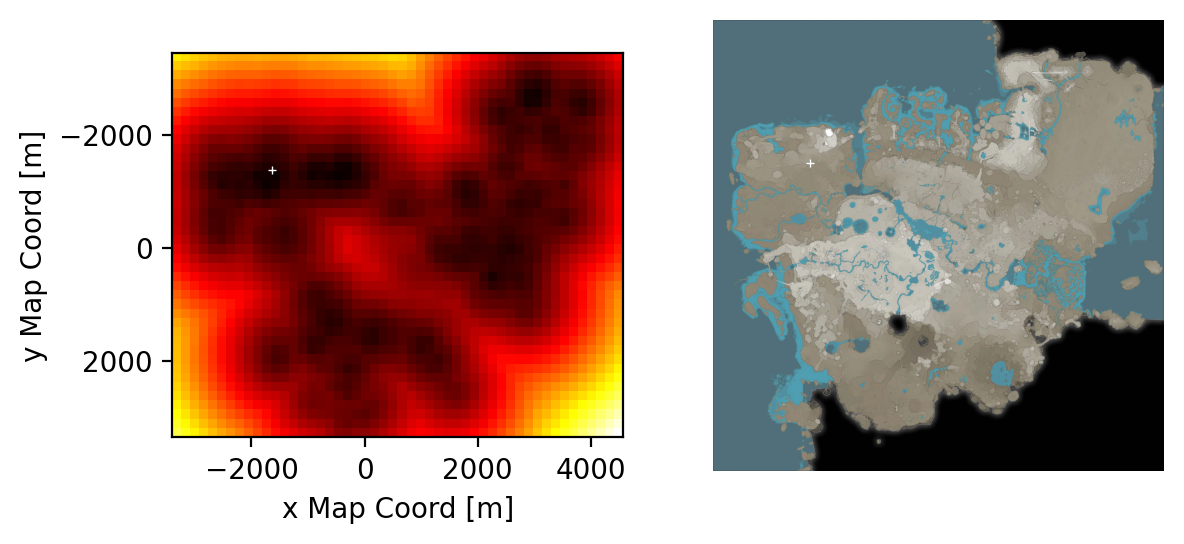

Search Results for Parameters:
Resource Types :['copper', 'iron', 'quartz', 'limestone']
Resource Rates :[138, 69, 118, 197]

Total Search Time: 17.115s
Map Points Analyzed: 2100

Best Location Found [-164000, -137000]

Closest Resource Nodes Found:


,pathName,x,y,z,type,purity,obstructed,lastCheck,maxRate
251,Persistent_Level:PersistentLevel.BP_ResourceNo...,-166357.250000,-129627.562500,1600.226685,copper,normal,False,NaN,600
262,Persistent_Level:PersistentLevel.BP_ResourceNo...,-186902.296875,-118339.828125,706.000000,iron,normal,False,NaN,600
289,Persistent_Level:PersistentLevel.BP_ResourceNo...,-167359.828125,-145682.578125,-1916.122559,quartz,pure,False,NaN,780
257,Persistent_Level:PersistentLevel.BP_ResourceNo...,-165001.937500,-133278.093750,1610.910156,limestone,pure,False,NaN,780


In [9]:
#Plot Heatmap ranked by cumulative_distance

#load the world map image
img = np.asarray(Image.open('/drive/data/world_map.png'))

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#data
# using subplot function and creating plot one
plt.subplot(1, 2, 1)  # row 1, column 2, count 1
plt.imshow(cumulative_distance.T, cmap='hot', interpolation='nearest', extent=[grid_x_start/100,grid_x_stop/100,grid_y_stop/100,grid_y_start/100], aspect=1)
#plt.plot([best_world_location[0]/100], [best_world_location[1]/100], '+', color = 'w', linewidth=5)
plt.scatter([best_world_location[0]/100], [best_world_location[1]/100],  s=10,marker='+',color='w',linewidth=.5)
plt.xlabel('x Map Coord [m]')
plt.ylabel('y Map Coord [m]')

#legend
#cbar = plt.colorbar()
minVal =  cumulative_distance.min()
maxVal =  cumulative_distance.max()
#cbar.set_ticks([minVal, maxVal])
#cbar.set_ticklabels(['Best', 'Worst'])

# using subplot function and creating plot two
# row 1, column 2, count 2
plt.subplot(1, 2, 2)
imgplot = plt.imshow(img, extent=[-324420/100,425250/100,374950/100,-374700/100], aspect=1)
plt.scatter([best_world_location[0]/100], [best_world_location[1]/100],  s=10,marker='+',color='w',linewidth=.5)
plt.axis('off')

plt.show()


#to show under plot for a screenshot all together
total_elapsed = time.time() - begin_tic
print('\033[1m' + 'Search Results for Parameters:')
print('\033[0m' + 'Resource Types :' + str(findTypes))
print('Resource Rates :' + str(findRates))
print('\nTotal Search Time: %.3fs' %  total_elapsed)
print('Map Points Analyzed: ' + str(total_points))
print('\nBest Location Found ' + str(best_world_location))
print('\nClosest Resource Nodes Found:')
best_df.head(len(best_node_ids_flat))